In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import glob
from saturation.utils import *

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "40g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

25/02/11 14:16:21 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/02/11 14:16:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/11 14:16:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [52]:
base_path = "/data/saturation/thesis_run_20250108/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))
configs_pdf["nstop"] = configs_pdf.stop_condition.apply(lambda x: x.get("ntot", -1))

In [54]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

# Comparisons of scenarios

### Negative Binomial Model

In [ ]:
configs_pdf

In [ ]:
min_simulation_id = 21
max_simulation_id = 230
selected_simulation_ids = list(range(min_simulation_id, max_simulation_id + 1))

configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].sort_values("simulation_id")

In [ ]:
df = get_statistics_with_lifespans_for_simulations(
    selected_simulation_ids,
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=100000
)
df

In [ ]:
models_by_sim_id = dict()

for simulation_id in df.simulation_id.drop_duplicates():
    d = df[df.simulation_id == simulation_id]

    # Fit a negative binomial model
    model = smf.negativebinomial(data=d, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="bfgs", cov_type="HC0")
    models_by_sim_id[simulation_id] = model

In [ ]:
data_to_plot = configs_pdf[configs_pdf.simulation_id.isin(models_by_sim_id.keys())].copy()
data_to_plot["fitted_slope"] = [models_by_sim_id[simulation_id].params.iloc[1] for simulation_id in models_by_sim_id.keys()]
data_to_plot["fitted_slope_std_err"] = [models_by_sim_id[simulation_id].bse.iloc[1] for simulation_id in models_by_sim_id.keys()]
data_to_plot

In [ ]:
data_to_plot[["simulation_id", "slope", "rim_erasure_exponent"]].sort_values(["rim_erasure_exponent", "slope"])

In [ ]:
fig = plt.figure(figsize=(9, 6), dpi=200)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(data_to_plot["rim_erasure_exponent"].min(), data_to_plot["rim_erasure_exponent"].max())

for rim_erasure_exponent in data_to_plot.rim_erasure_exponent.drop_duplicates().sort_values():
    d = data_to_plot[data_to_plot.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.errorbar(
        d.slope,
        d.fitted_slope,
        d.fitted_slope_std_err,
        marker="+",
        color=cm.viridis(norm(rim_erasure_exponent)),
        ecolor=cm.viridis(norm(rim_erasure_exponent))
    )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Erasure Exponent')

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\beta_1}$", fontsize=font_size)

plt.show()

### Diagnostics on best model across slopes (-3, -5)

In [ ]:
# Best model so far
max_slope = -2.99
min_slope = -5.01
data = df[(df.slope.between(min_slope, max_slope))].copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

In [ ]:
residuals = model.resid_pearson
plt.hist(residuals, bins=30)
plt.title("Histogram of Pearson Residuals")
plt.show()

In [ ]:
predicted = model.predict()
plt.scatter(predicted, model.model.endog)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicted vs Observed")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white


# Extract Pearson residuals
pearson_residuals = model.resid_pearson

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(pearson_residuals, model.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

print("Breusch-Pagan Test:")
print(dict(zip(bp_labels, bp_test)))

# Perform the White test
white_test = het_white(pearson_residuals, model.model.exog)
white_labels = ['Test Statistic', 'p-value', 'f-value', 'f p-value']

print("\nWhite Test:")
print(dict(zip(white_labels, white_test)))

# Interpretation:
# A small p-value (e.g., < 0.05) suggests evidence of heteroscedasticity.

In [ ]:
model.model.exog_names

In [ ]:
for i in range(1, len(model.model.exog_names) - 1):  # Skip the intercept and alpha
    plt.scatter(model.model.exog[:, i], pearson_residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(f"Predictor {model.model.exog_names[i]}")
    plt.ylabel("Pearson Residuals")
    plt.title(f"Residuals vs. Predictor {model.model.exog_names[i]}")
    plt.show()

In [ ]:
# Plot Pearson residuals vs fitted values
data["fitted_values"] = model.fittedvalues
data["log_fitted_values"] = np.log(model.fittedvalues)
data["log_radius"] = np.log(data.radius)
data["log_lifespan"] = np.log(data.lifespan)
var_names = ["slope", "log_radius", "radius", "fitted_values", "lifespan", "rim_erasure_exponent"]
for var_name in var_names:
    plt.scatter(data[var_name], model.resid_pearson, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(var_name)
    plt.ylabel("Pearson residuals")
    plt.title(f"Pearson Residuals vs. {var_name}")
    plt.show()

In [ ]:
# Let's check the whole range
max_slope = -1.99
min_slope = -7
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

In [ ]:
# Let's check the whole range
max_slope = -0.1
min_slope = -7
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

In [ ]:
predicted = model.predict()
plt.scatter(predicted, model.model.endog)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicted vs Observed")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
# Plot Pearson residuals vs fitted values
data["fitted_values"] = model.fittedvalues
data["log_fitted_values"] = np.log(model.fittedvalues)
data["log_radius"] = np.log(data.radius)
data["log_lifespan"] = np.log(data.lifespan)
var_names = ["slope", "log_radius", "radius", "fitted_values", "lifespan", "rim_erasure_exponent"]
for var_name in var_names:
    plt.scatter(data[var_name], model.resid_pearson, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(var_name)
    plt.ylabel("Pearson residuals")
    plt.title(f"Pearson Residuals vs. {var_name}")
    plt.show()

### With Slopes >= -1.7

In [ ]:
max_slope = -1.99
min_slope = -2.49
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

In [ ]:
max_slope = -0.5
min_slope = -1.8
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

## Shallow slope

In [62]:
scenario_name = "shallow_slope"
selected_slope = -1
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = 1
max_ntot = configs_dict[selected_simulation_id]["stop_condition"]["ntot"]
filtered

,mrp,r_min,rim_erasure_method,rmult,simulation_id,slope,stop_condition,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio,nstop
214,0.5,0.6,"{'name': None, 'ratio': 5.0}",1.5,1.0,-1.0,"{'ntot': '2500000', 'name': 'ntot'}",250.0,2000.0,-1.0,5.0,2500000
246,0.5,0.6,"{'name': None, 'ratio': 5.0}",1.5,7.0,-1.0,"{'ntot': '50000000', 'name': 'ntot'}",250.0,2000.0,-1.0,5.0,50000000
390,0.5,0.6,"{'name': None, 'ratio': 1000000.0}",1.5,20.0,-1.0,"{'ntot': '1000000', 'name': 'ntot'}",250.0,2000.0,-1.0,1000000.0,1000000


In [18]:
data = get_statistics_with_lifespans_for_simulations(
    [selected_simulation_id],
    base_path,
    configs_df,
    spark,
)
data

,x,y,radius,simulation_id,nstat,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,928.340881,1874.422974,4.554950,1,1,1,0.000016,-1.0,0.5,1.5,NaN,5.0,0.0,3316.0
1,534.016907,598.395447,4.848379,1,2,2,0.000035,-1.0,0.5,1.5,NaN,5.0,0.0,132.0
2,267.311737,620.069275,3.901614,1,3,3,0.000047,-1.0,0.5,1.5,NaN,5.0,0.0,5497.0
3,1355.257690,561.308167,5.236776,1,4,4,0.000068,-1.0,0.5,1.5,NaN,5.0,0.0,3767.0
4,1480.961548,1456.479858,4.076553,1,5,5,0.000082,-1.0,0.5,1.5,NaN,5.0,0.0,2073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,1532.274536,1719.136230,7.421506,1,2499996,455,0.444217,-1.0,0.5,1.5,NaN,5.0,0.0,NaN
2499996,1301.648560,361.871460,3.093483,1,2499997,456,0.444224,-1.0,0.5,1.5,NaN,5.0,0.0,NaN
2499997,495.619934,356.117920,3.841865,1,2499998,457,0.444235,-1.0,0.5,1.5,NaN,5.0,0.0,NaN
2499998,1793.826172,1068.358398,3.315536,1,2499999,458,0.444244,-1.0,0.5,1.5,NaN,5.0,0.0,NaN


nobs line: 391.5


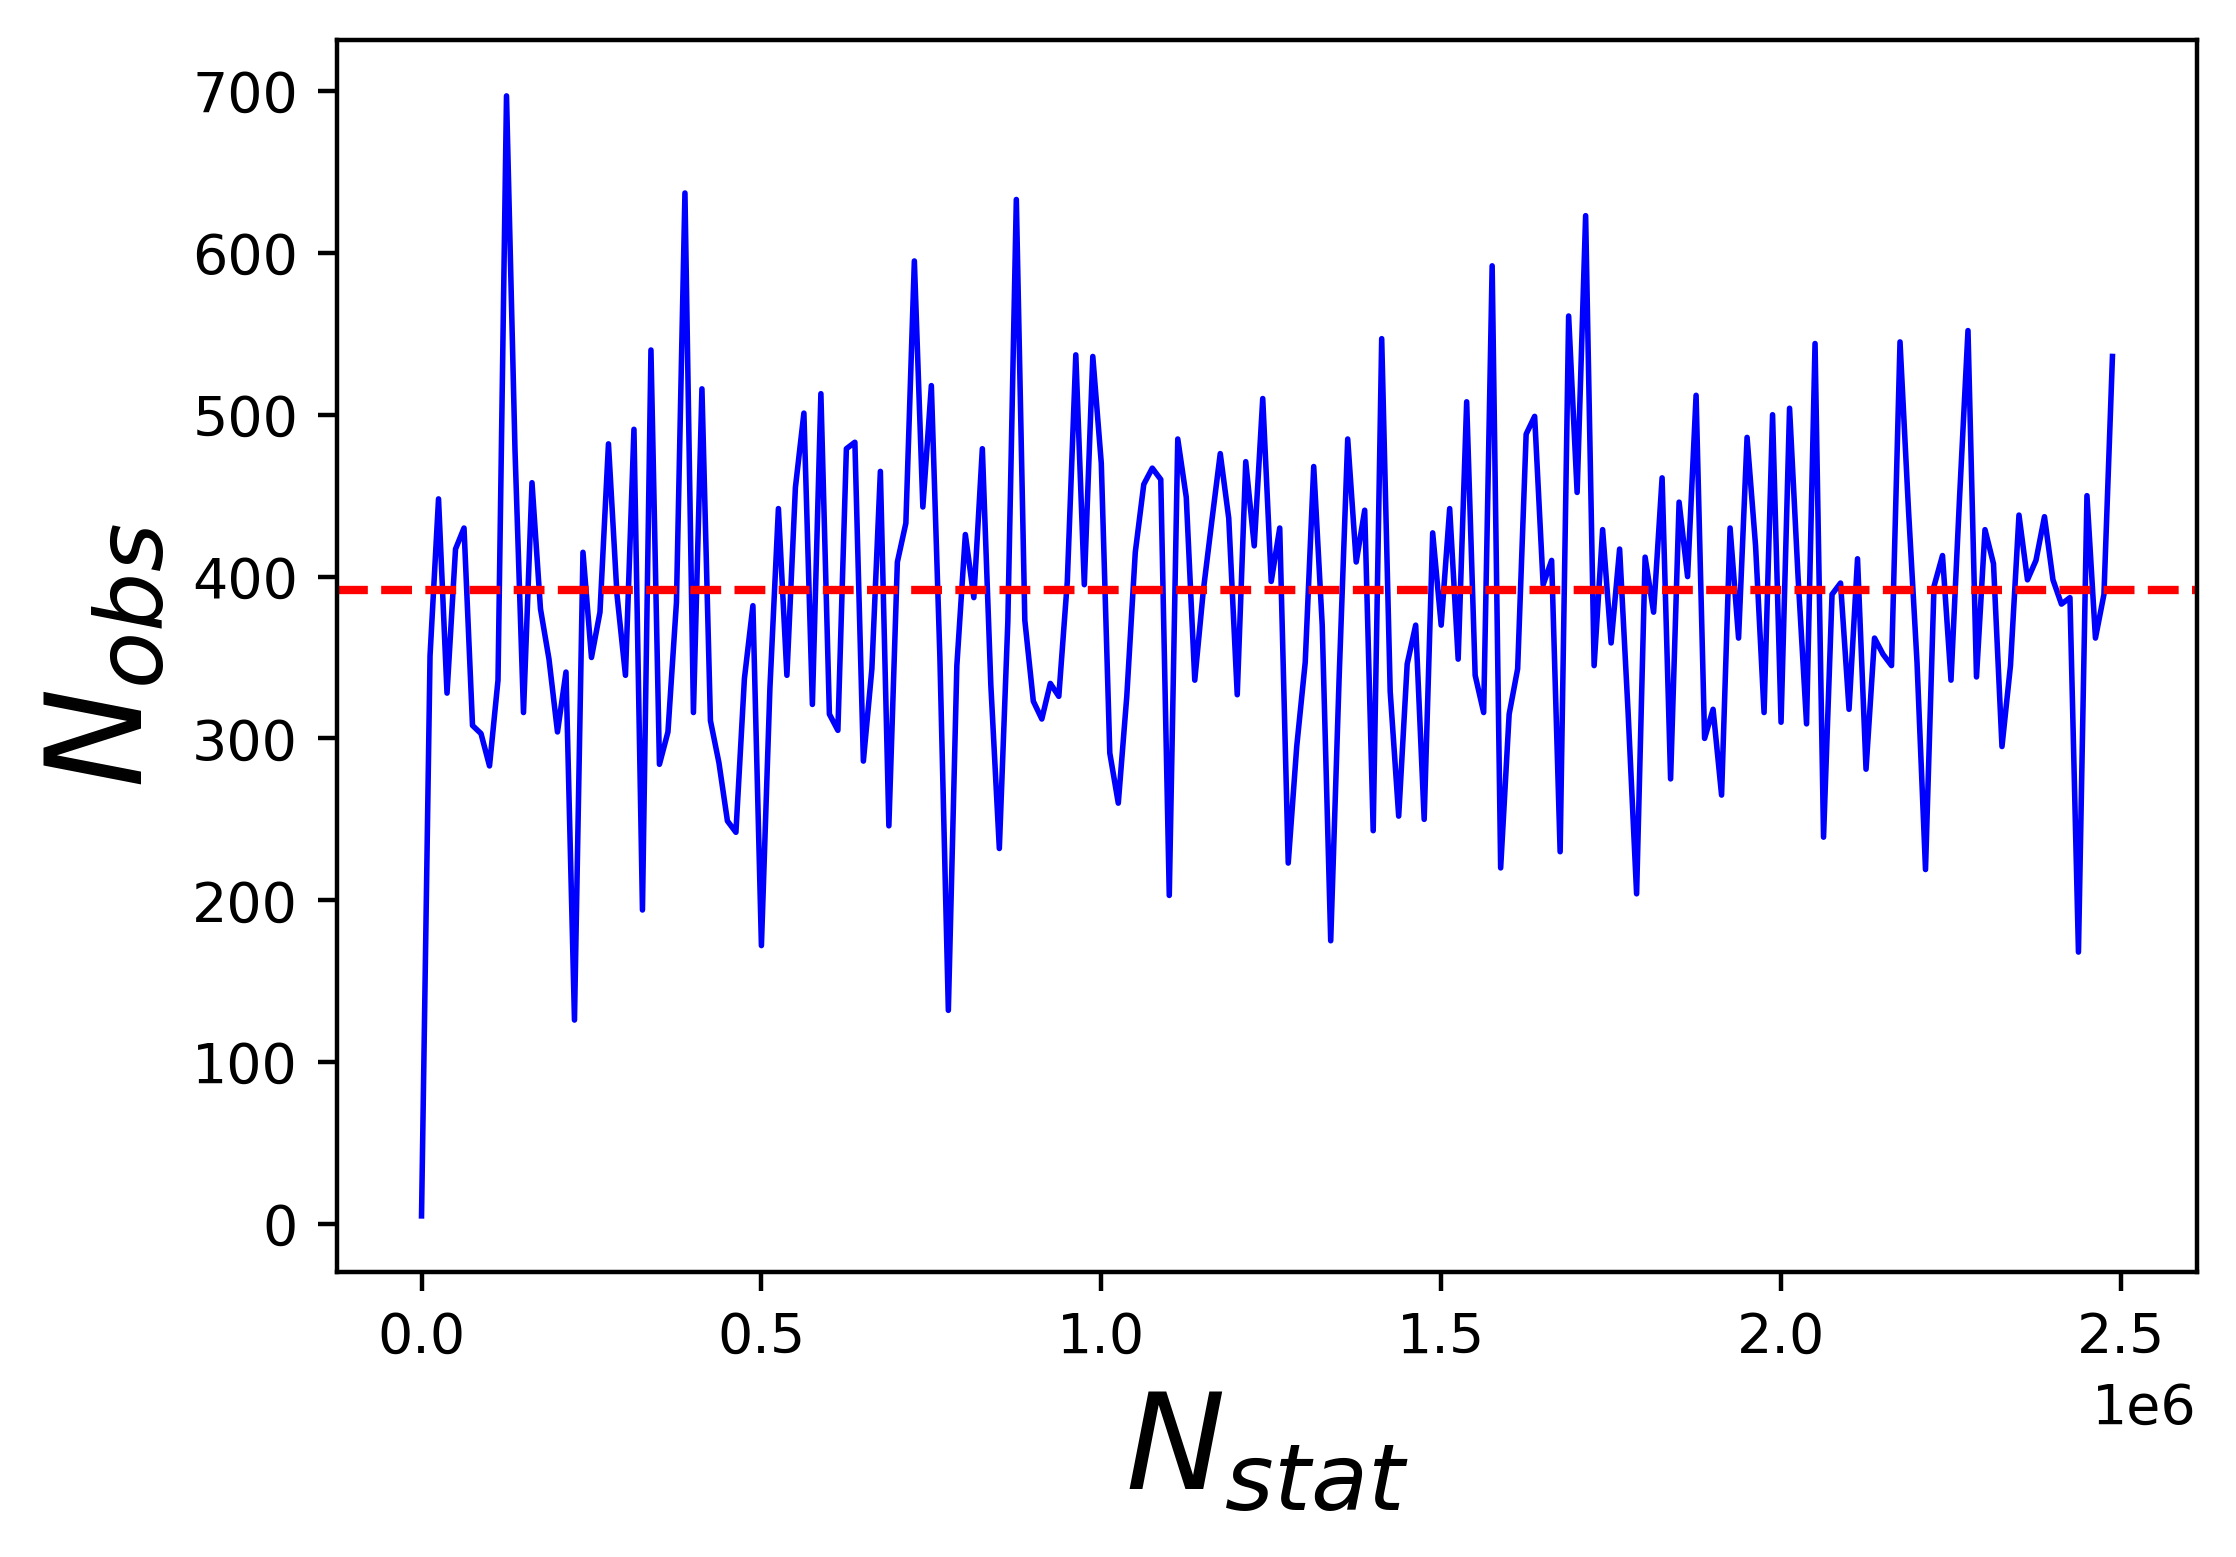

In [56]:
n_samples = 200
df = data[(data.simulation_id == selected_simulation_id) & (data.nstat % (max_ntot // n_samples) == 5)]

fig = plt.figure(figsize=(6, 4), dpi=dpi)
ax1 = fig.add_subplot(111)

nobs_line = df[-(max_ntot // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{stat}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_nstat_nobs.png", bbox_inches="tight")

nobs line: 369.0


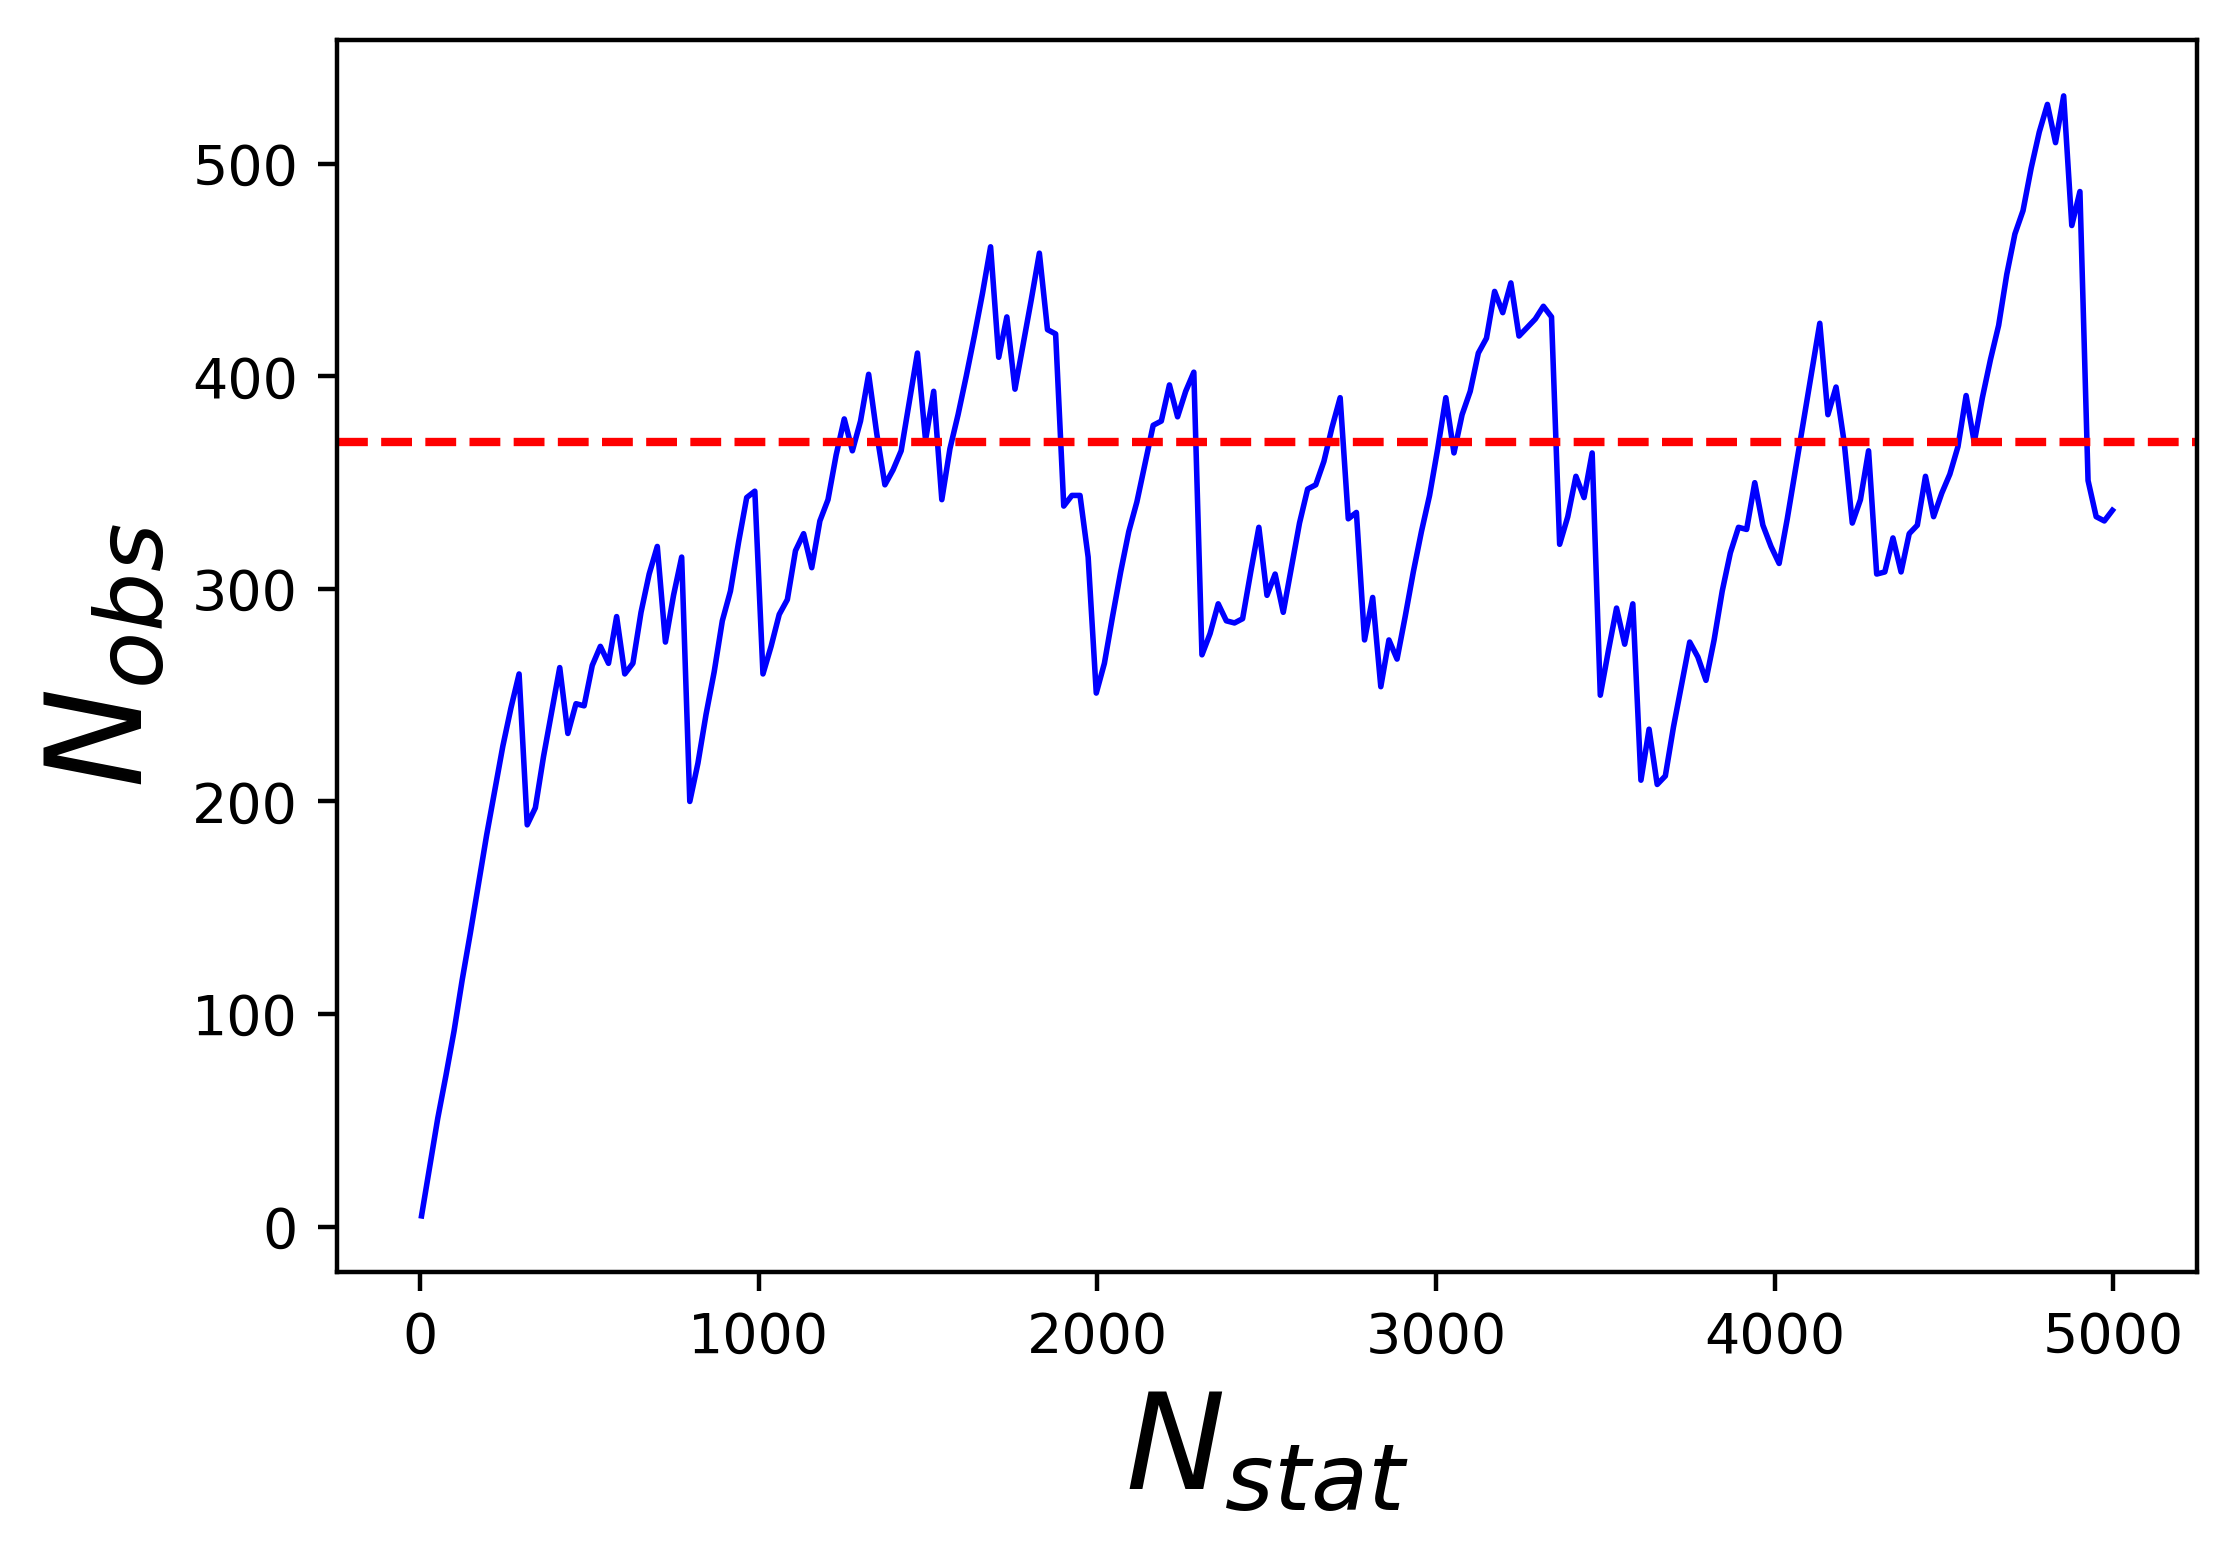

In [57]:
n_samples = 200
df = data[
    (data.simulation_id == selected_simulation_id)
    & (data.nstat < 5000)
]
df = df[df.nstat % (max_ntot // n_samples) == 5]

fig = plt.figure(figsize=(6, 4), dpi=dpi)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{stat}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_nstat_nobs_beginning.png", bbox_inches="tight")

Optimization terminated successfully.
         Current function value: 9.024926
         Iterations: 2
         Function evaluations: 85


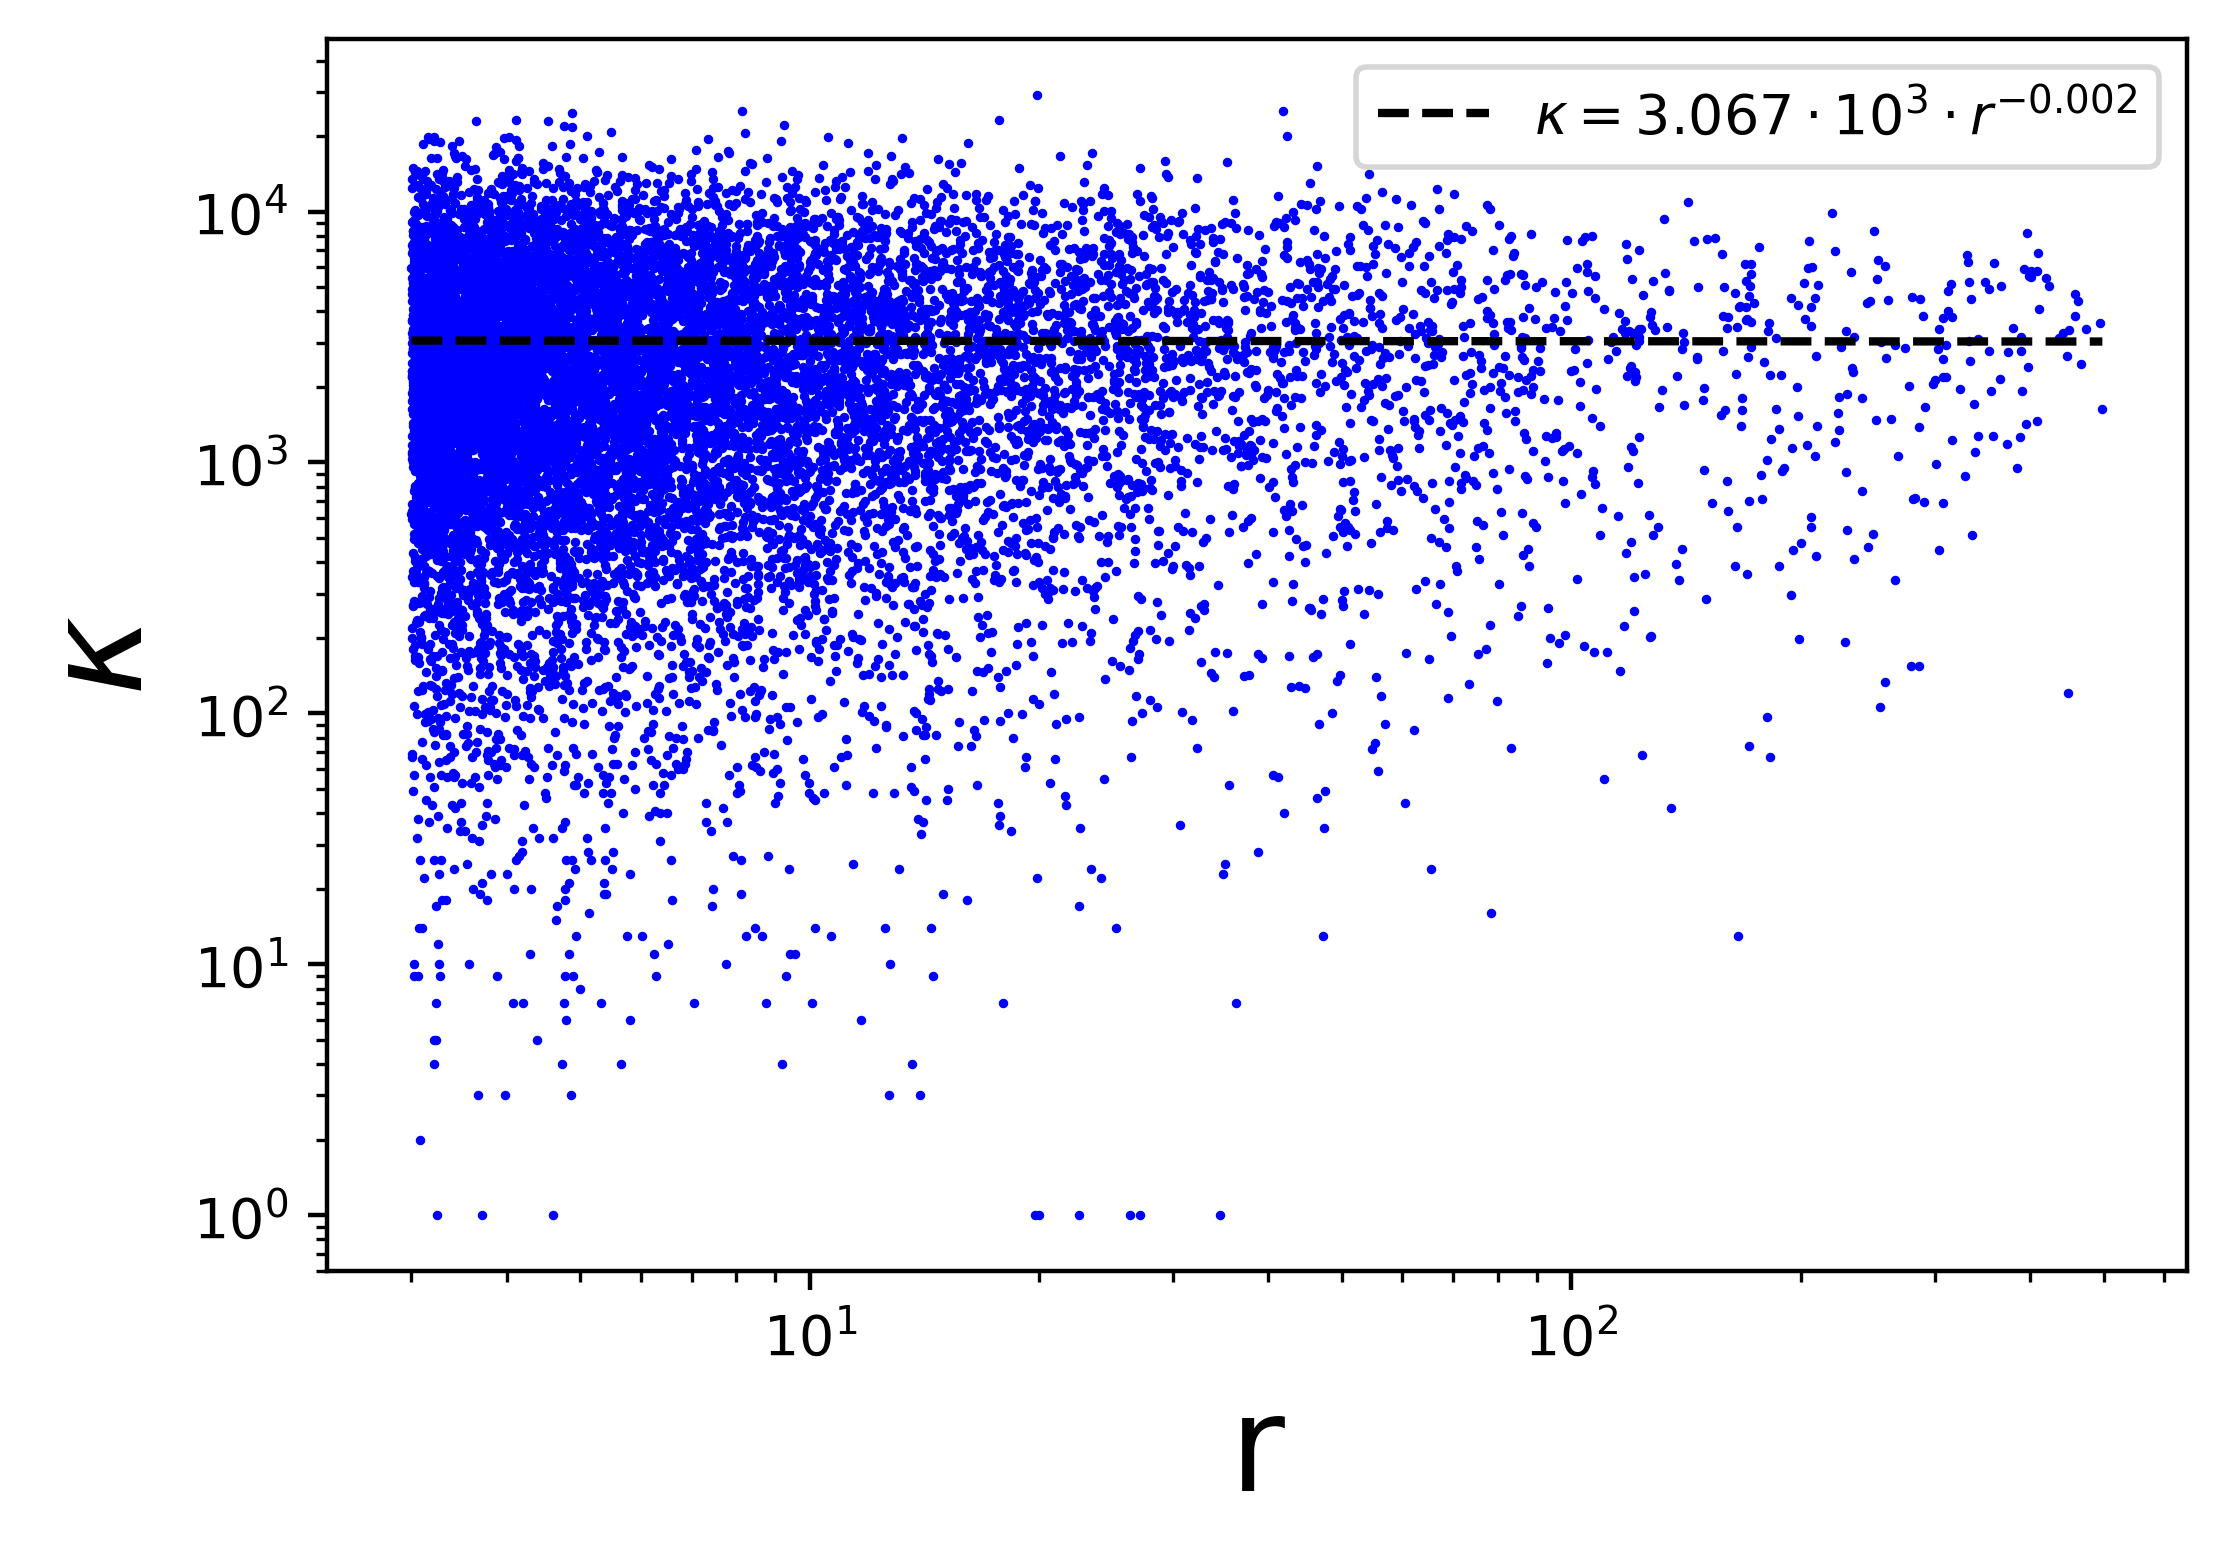

In [58]:
plt.figure(figsize=(6, 4), dpi=dpi)

# Sampled scatterplot
model_data = data[~data.lifespan.isna()]
sampled = model_data.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifespan,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.negativebinomial(data=model_data, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="powell", cov_type="HC0")
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius")),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [59]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               lifespan   No. Observations:              2499543
Model:               NegativeBinomial   Df Residuals:                  2499541
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Feb 2025   Pseudo R-squ.:               1.437e-07
Time:                        15:07:09   Log-Likelihood:            -2.2558e+07
converged:                       True   LL-Null:                   -2.2558e+07
Covariance Type:                  HC0   LLR p-value:                   0.01089
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.0285      0.001   5456.052      0.000       8.026       8.031
np.log(radius)    -0.0017      0.001     -2.772      0.006      -0.003      -0.001
alpha              0.9772      0.001   1268.349      0.000       0.976       0.979
==================================================================================
"""

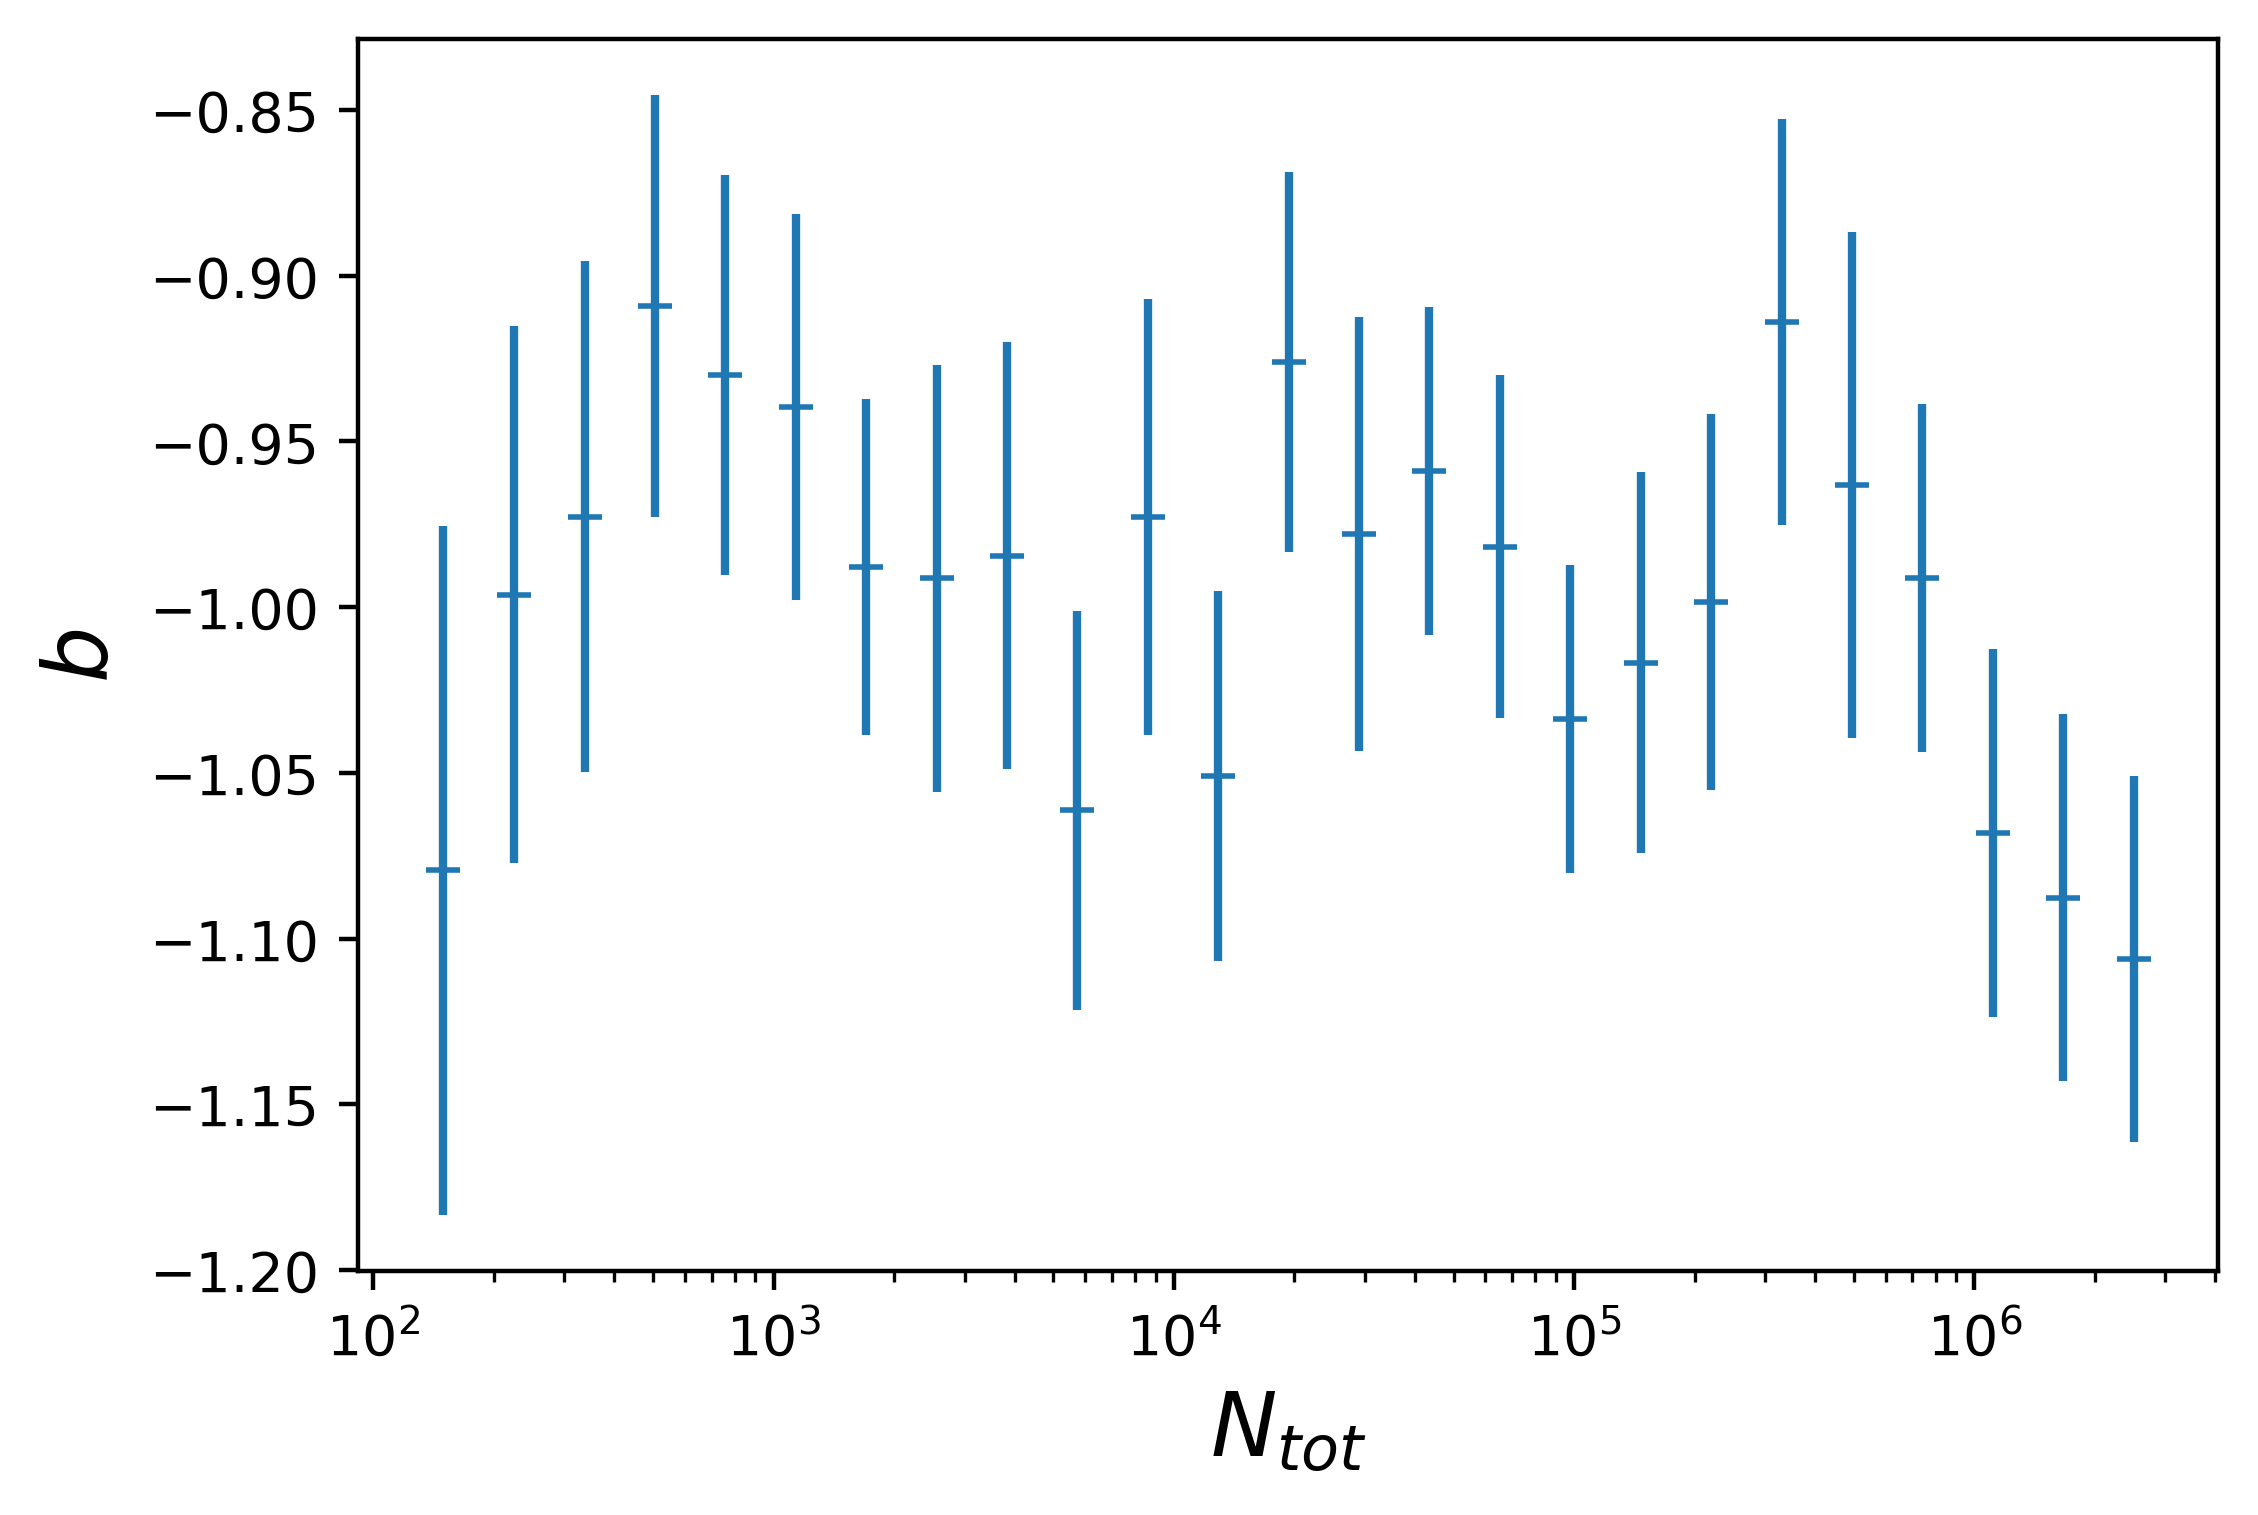

In [61]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=max_ntot
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

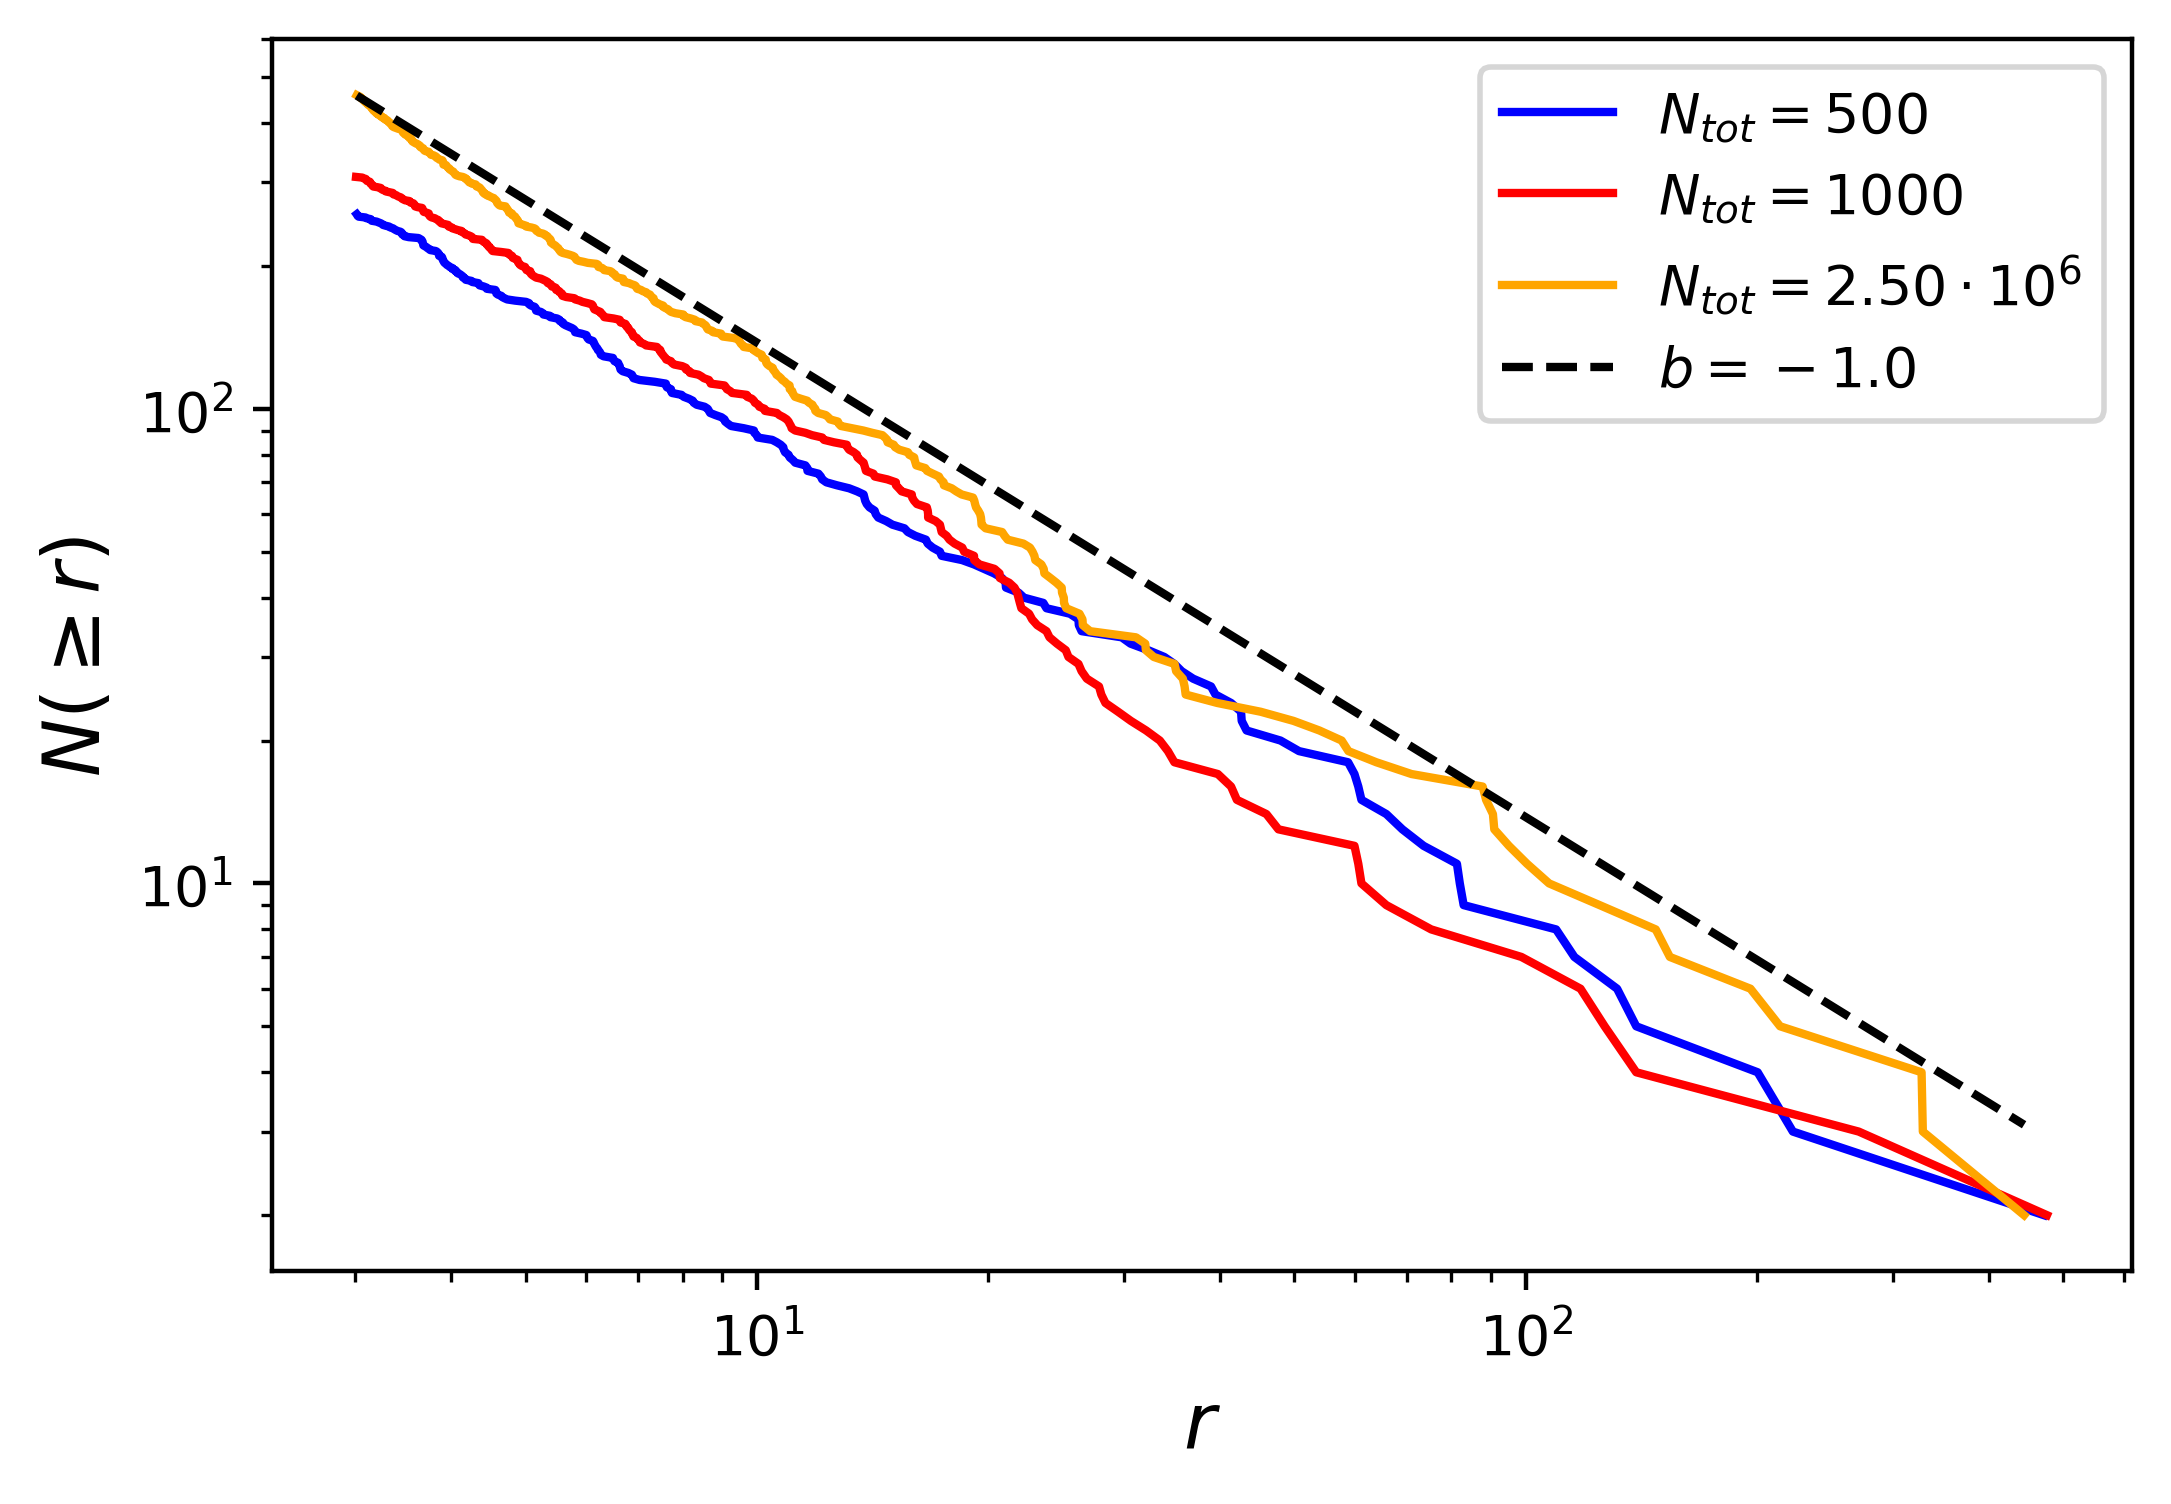

In [63]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[500, 1000, max_ntot],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "dashed", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Steep slope

In [ ]:
scenario_name = "steep_slope"
selected_slope = -4
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = 2
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
fitted_model = NegativeBinomial(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)

fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

In [ ]:
fitted_model.summary()

In [ ]:
np.log(0.1233)

In [ ]:
lifetimes.lifetime.mean(), lifetimes.lifetime.var()

In [ ]:
sorted_sampled = sampled.sort_values("radius")

n_chunks = 4
n_samples = sorted_sampled.shape[0] // n_chunks
ks_2samp(sorted_sampled.lifetime[:n_samples], sorted_sampled.lifetime[n_samples * (n_chunks - 2):n_samples * (n_chunks - 1)])

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=2.5 * 10 ** 6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[250, 5000, int(2.5 * 10 ** 6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -4.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## High destruction, b = -2.5

In [ ]:
scenario_name = "high_destruction"
selected_slope = -2.5
selected_mrp = 0.75
selected_rmult = 1.9

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue",
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
%history -g -f history.txt

In [ ]:
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial

# fitted_model = Poisson(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)
# fitted_model = NegativeBinomial(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)
fitted_model = smf.negativebinomial("lifetime ~ 1 + np.log(radius)", data=lifetimes).fit()

fitted_model.summary()

In [ ]:
fitted_values

In [ ]:
sm.genmod.families.family.NegativeBinomial(alpha=0.5337).deviance(
    endog=lifetimes.lifetime,
    mu=fitted_model.predict(lifetimes),  
) / fitted_model.df_resid

In [ ]:
np.sum(fitted_model.resid_pearson**2) / fitted_model.df_resid

In [ ]:
data = lifetimes

In [ ]:
fitted_model.predict(data)

In [ ]:
# 1. Residual Analysis
# Raw residuals
data['raw_residuals'] = data['lifetime'] - fitted_model.predict(data)

# Pearson residuals
data['pearson_residuals'] = data['raw_residuals'] / np.sqrt(fitted_model.predict(data))

# Deviance residuals
# data['deviance_residuals'] = fitted_model.resid_deviance

# Plot residuals against fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_model.predict(data), data['pearson_residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Pearson Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# 2. Leverage and Influence
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(fitted_model)
data['hat_values'] = influence.hat_matrix_diag
data['cooks_distance'] = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(data.index, data['cooks_distance'], markerfmt=",", use_line_collection=True)
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance for Each Observation')
plt.show()

# 3. Goodness-of-Fit
# Deviance and Pearson Chi-Square statistics
deviance = model.deviance
pearson_chi2 = np.sum(data['pearson_residuals']**2)
df_residual = model.df_resid

print(f"Deviance: {deviance}")
print(f"Pearson Chi-Square: {pearson_chi2}")
print(f"Degrees of Freedom: {df_residual}")
print(f"Deviance/DF: {deviance / df_residual:.2f}")
print(f"Pearson Chi-Square/DF: {pearson_chi2 / df_residual:.2f}")

# 4. Predicted vs Observed Counts
plt.figure(figsize=(8, 6))
plt.scatter(data['y'], model.fittedvalues, alpha=0.7)
plt.plot([min(data['y']), max(data['y'])], [min(data['y']), max(data['y'])], color='red', linestyle='--', linewidth=1)
plt.xlabel('Observed Counts')
plt.ylabel('Predicted Counts')
plt.title('Observed vs Predicted Counts')
plt.show()

# 5. Multicollinearity Diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant for VIF calculation
X = sm.add_constant(data[['x1', 'x2']])
vif = pd.DataFrame({
    'Variable': ['const', 'x1', 'x2'],
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=2.5 * 10 ** 6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[250, 5000, int(2.5 * 10 ** 6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Low destruction, slope = -2.5

Ntot/nobs plot and Z/Za plots restricted in range to show Z/Za reaching significance before "saturation"

In [ ]:
scenario_name = "low_destruction"
selected_slope = -2.5
selected_mrp = 0.25
selected_rmult = 1.1

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=2.5 * 10 ** 6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[500, 2500, 2500000],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dashed", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, shallow slope

In [ ]:
scenario_name = "no_erasure_threshold_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 139

# filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=10 ** 7
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[1000, 1e6, int(10 ** 7)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, steep slope

In [ ]:
scenario_name = "no_erasure_threshold_steep_slope"
selected_slope = -4.0
# selected_slope = -3.5
selected_simulation_id = 142

# filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# plt.figure(figsize=(6, 4), dpi=400)

# # Sampled scatterplot
# sampled = lifetimes.sample(frac=0.005)
# plt.scatter(
#     sampled.radius,
#     sampled.lifetime,
#     c="blue",
#     s=.5,
# )

# # Fit the line in log space
# fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
# fitted_intercept = np.exp(fitted_model.params.iloc[0])
# fitted_slope = fitted_model.params.iloc[1]

# plt.plot(
#     [sampled.radius.min(), sampled.radius.max()],
#     np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
#     ls="dashed",
#     c="black",
#     label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
# )

# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("r", fontsize=font_size)
# plt.ylabel("$\\kappa$", fontsize=font_size)
# plt.legend()

# plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
# plt.show()

In [ ]:
sorted_lifetimes = lifetimes.sort_values("radius")

n_samples_each = 1000
offset = sorted_lifetimes.shape[0] // 10
sample_sets = [
    sorted_lifetimes.lifetime[offset * x: offset * (x + 1)].sample(n_samples_each)
    for x in range(5)
]
result = anderson_ksamp(sample_sets)

print("Statistic:", result.statistic)
print("P-value:", result.pvalue)

if result.pvalue < 0.05:
    print("Reject the null hypothesis: The distributions are different.")
else:
    print("Fail to reject the null hypothesis: The distributions are not significantly different.")

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=10 ** 7
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[1000, 1e6, int(10 ** 7)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Square root threshold function

In [ ]:
scenario_name = "square_root_threshold"
selected_slope = -3.5
selected_simulation_id = 136

filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=2.5 * 10 ** 6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[1000, 1e6, int(2.5 * 10 ** 6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -3.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Fourth root threshold function

In [ ]:
scenario_name = "fourth_root_threshold"
selected_slope = -3.5
selected_simulation_id = 137

filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=2.5 * 10 ** 6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[1000, 1e6, int(2.5 * 10 ** 6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -3.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Investigating lifetime for a range of slopes

In [ ]:
scenario_name = "nu_vs_slope"
selected_simulation_ids = set(range(5, 110))

filtered = configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].sort_values("simulation_id")
filtered

In [ ]:
sample_fraction = 0.25
craters_sampled = craters.where(F.col("simulation_id").isin(selected_simulation_ids)).sample(sample_fraction).cache()
removals_cached = removals.where(F.col("simulation_id").isin(selected_simulation_ids)).cache()

In [ ]:
all_lifetimes = dict()
all_models = dict()

for row in filtered.itertuples():
    lifetimes = get_lifetimes_for_simulation(
        simulation_id=row.simulation_id,
        craters=craters_sampled,
        removals=removals_cached,
        configs_df=configs_df,
        spark=spark
    )
    all_lifetimes[row.simulation_id] = lifetimes

    # Fit the line in log space
    # fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
    fitted_model = NegativeBinomial(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)
    all_models[row.simulation_id] = fitted_model

In [ ]:
df = filtered.copy()
df["fitted_slope"] = [all_models[simulation_id].params.iloc[1] for simulation_id in df.simulation_id]
df["fitted_slope_std_err"] = [all_models[simulation_id].bse.iloc[1] for simulation_id in df.simulation_id]
df

In [ ]:
fig = plt.figure(figsize=(9, 6), dpi=400)
ax = fig.add_subplot(111)

low_mrp = df[df.mrp == 0.25]
ax.errorbar(
    low_mrp.slope,
    low_mrp.fitted_slope,
    low_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="b",
    label="$M_{r} = 0.25$"
)

high_mrp = df[df.mrp == 0.75]
ax.errorbar(
    high_mrp.slope,
    high_mrp.fitted_slope,
    high_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="orange",
    label="$M_{r} = 0.75$"
)

# Fit the line using OLS
steeper_slopes = df[df.slope < -2.5]
fitted_model = smf.ols(data=steeper_slopes, formula="fitted_slope ~ 1 + slope").fit()
fitted_intercept = fitted_model.params.iloc[0]
fitted_slope = fitted_model.params.iloc[1]

slopes_to_predict = pd.Series([-5.0, -1.8], name="slope")
ax.plot(
    slopes_to_predict,
    fitted_model.predict(slopes_to_predict),
    c="black",
    ls="dotted",
    label=f"$\\hat{{\\nu}} ={fitted_slope:.2f} \\cdot b - {-fitted_intercept:.2f}$"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\nu}$", fontsize=font_size)
ax.legend()

plt.savefig(f"figures/{scenario_name}_entire_range.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
craters_sampled.unpersist()
removals_cached.unpersist()

## Extended simulation, shallow slope

In [ ]:
scenario_name = "long_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 135

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

In [ ]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.nstat,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters.where(F.col("simulation_id") == selected_simulation_id).sample(0.25),
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.001)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_nstat=50000000
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntats(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_nstats=[500, 100000, int(5e7)],
    spark=spark
)

equilibrium_slope = -1.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_nstat(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")